In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
%matplotlib inline

spark=SparkSession.builder \
.master ("local[*]")\
.appName("MiniProject2")\
.getOrCreate()

In [3]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
from platform import python_version
print(python_version())

3.10.6


In [5]:
sc.version #spark version

'3.3.1'

In [6]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("../data/XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.")

There are 41188 rows 21 columns in the data.


In [7]:
df.show(4)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [8]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



In [10]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' ]
df.select(numeric_features).describe().toPandas().set_index('summary').transpose()

summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646455,0,4918
campaign,41188,2.567592502670681,2.770013542902331,1,56
pdays,41188,962.4754540157328,186.910907344741,0,999
previous,41188,0.17296299893172767,0.49490107983928927,0,7


In [11]:
df_renamed = df.withColumnRenamed("cons.price.idx","cons_price_idx")\
.withColumnRenamed("emp.var.rate", "emp_var_rate")\
.withColumnRenamed("cons.conf.idx","cons_conf_idx")\
.withColumnRenamed("nr.employed", "nr_employed")

In [12]:
df_renamed.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [31]:
numeric_features = [t[0] for t in df_renamed.dtypes if t[1] == 'double' or t[1] =='int']
df_renamed.select(numeric_features).describe().toPandas().set_index('summary').transpose()

summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646455,0,4918
campaign,41188,2.567592502670681,2.770013542902331,1,56
pdays,41188,962.4754540157328,186.910907344741,0,999
previous,41188,0.17296299893172767,0.49490107983928927,0,7
emp_var_rate,41188,0.08188550063178966,1.57095974051703,-3.4,1.4
cons_price_idx,41188,93.5756643682899,0.5788400489540823,92.201,94.767
cons_conf_idx,41188,-40.502600271918276,4.628197856174573,-50.8,-26.9
euribor3m,41188,3.621290812858533,1.7344474048512595,0.634,5.045
nr_employed,41188,5167.035910943957,72.25152766826338,4963.6,5228.1


In [29]:
from pyspark.sql.functions import col,isnan, when, count
df_renamed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_renamed.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



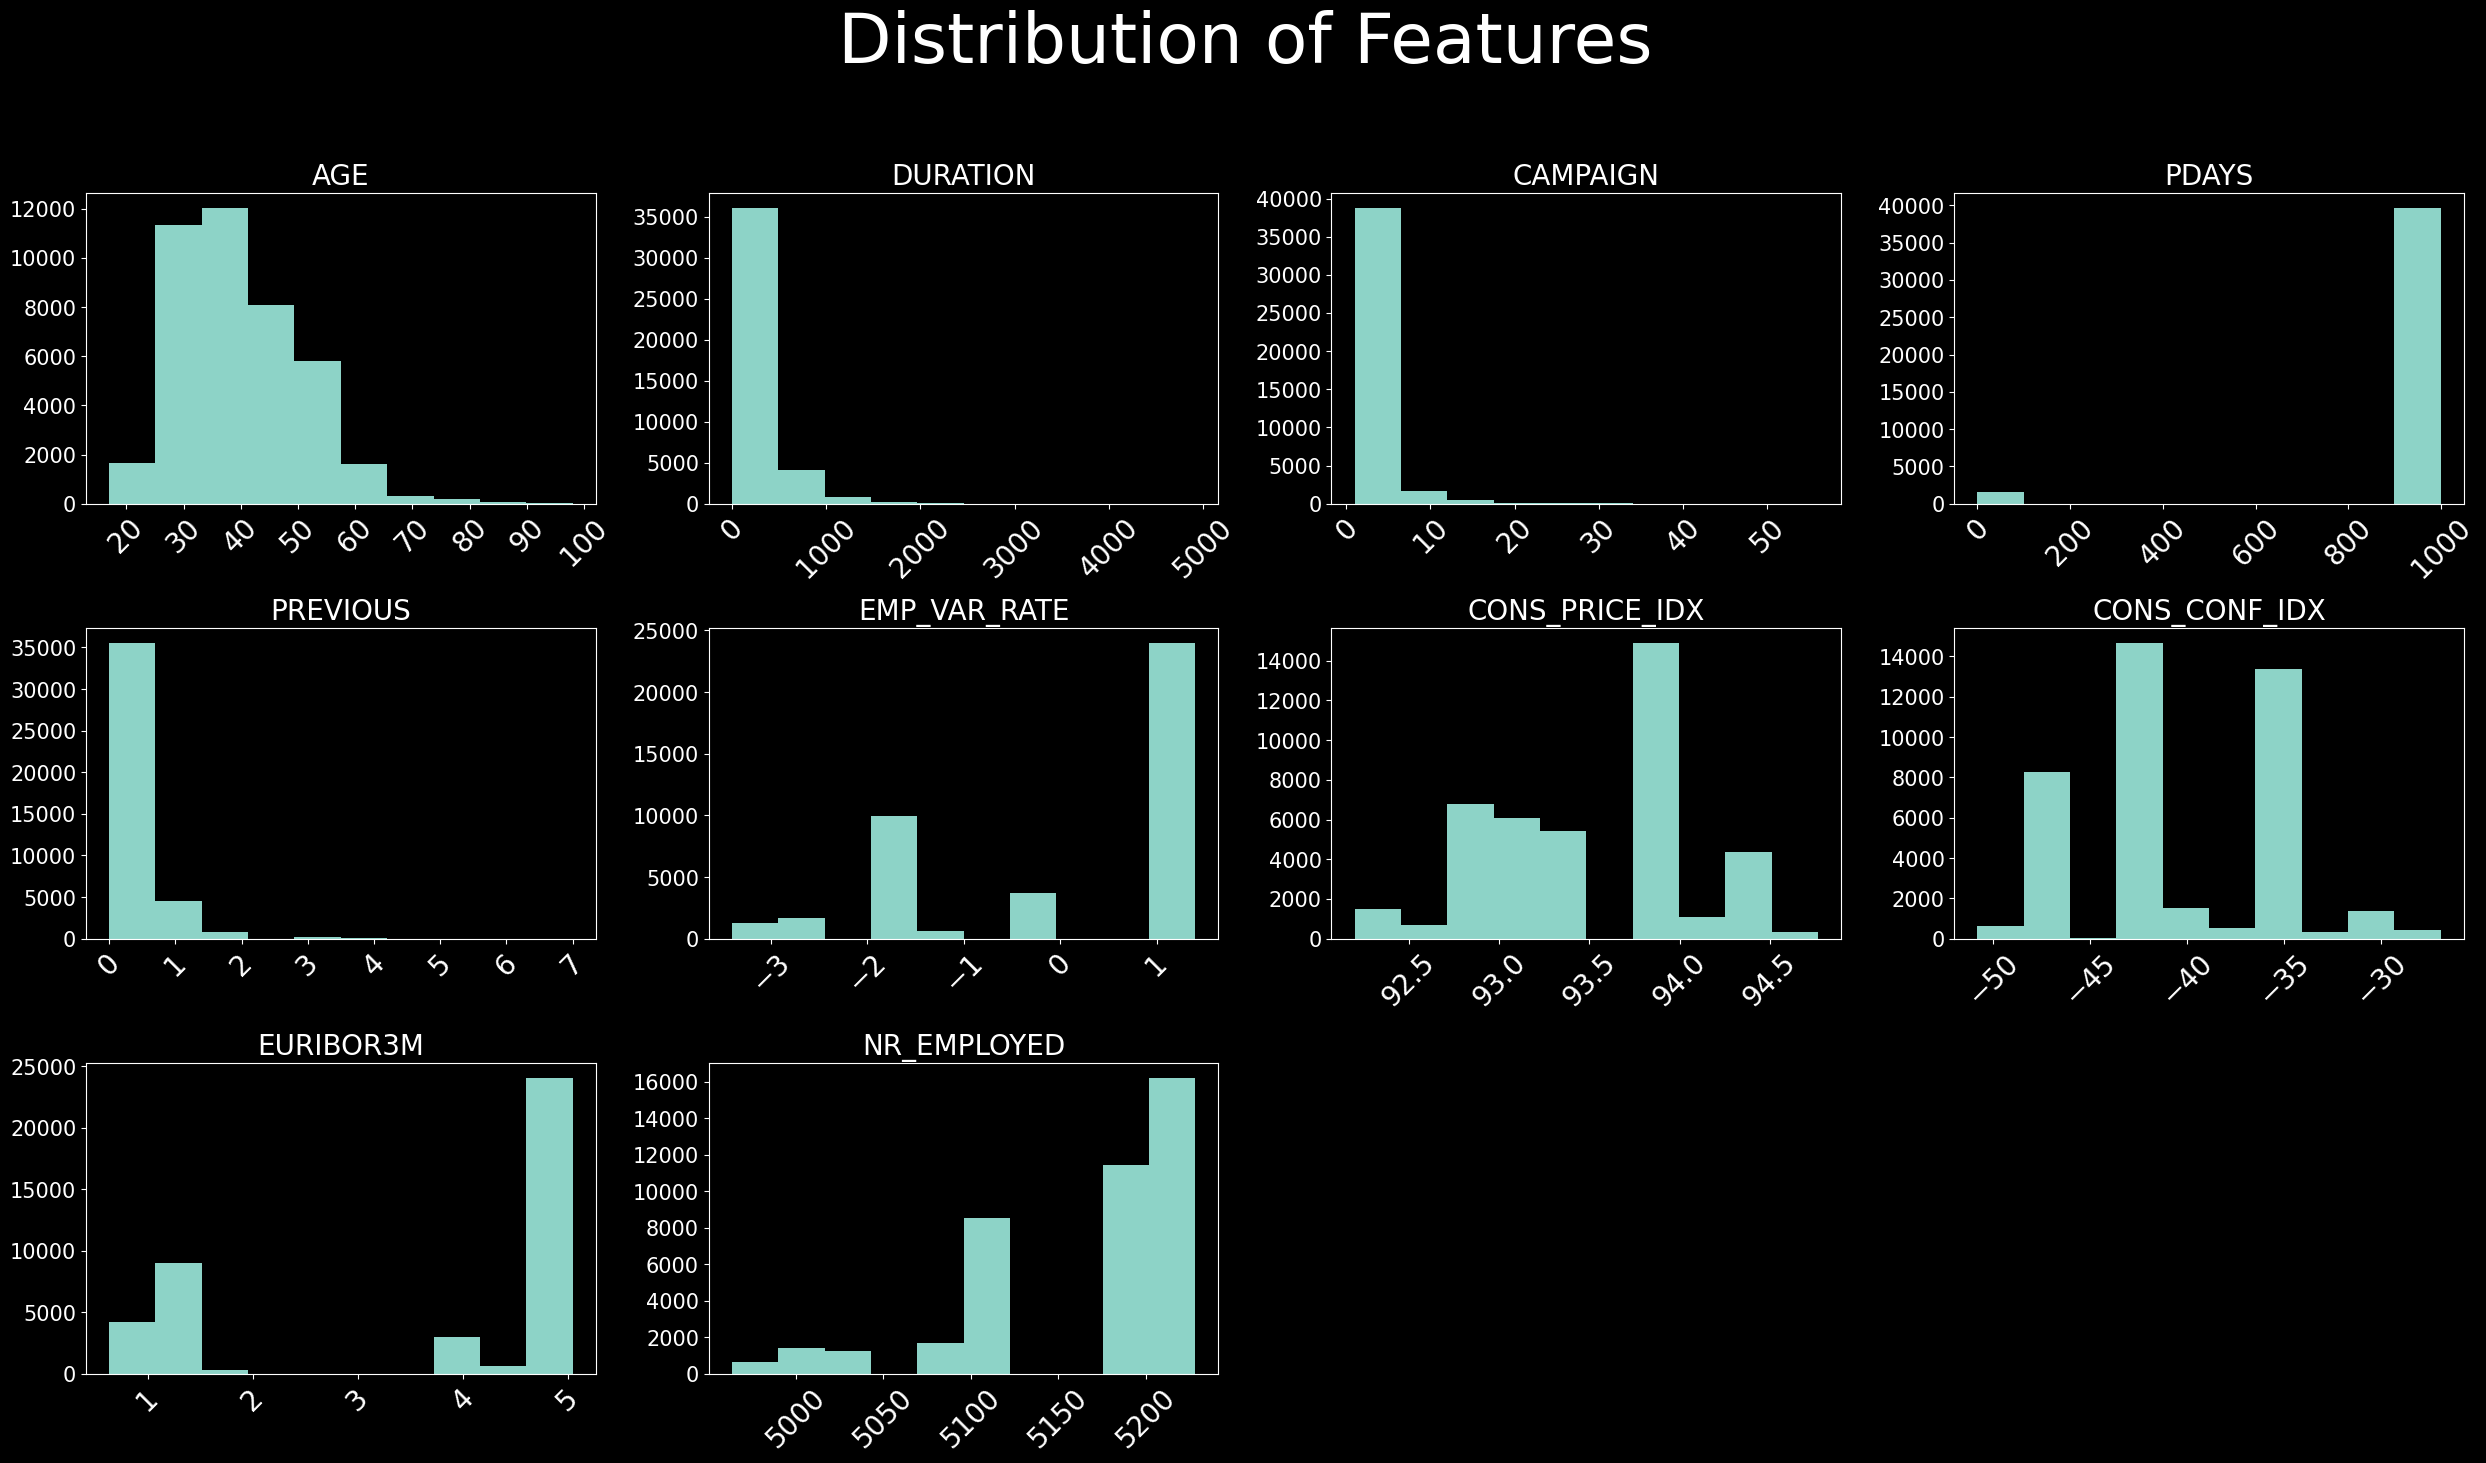

In [15]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df_renamed.toPandas().describe().columns, range(1,22)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df_renamed.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

Null values within certain columns have been assigned numeric values. In order to properly gauget the distributions of the variables those values will be replaced by nulls and a null indicator column will be added for each. 

In [237]:
from pyspark.sql.functions import when

df3 = df_renamed.withColumn("wasPreviouslyContacted",when(df_renamed.pdays==999,0).otherwise(1))

In [238]:
df3.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+----------------------+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|wasPreviouslyContacted|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+----------------------+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|                     0|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0

In [239]:
df3=df3.withColumn("pdays",when(df3.pdays==999,np.nan).otherwise(df3.pdays))

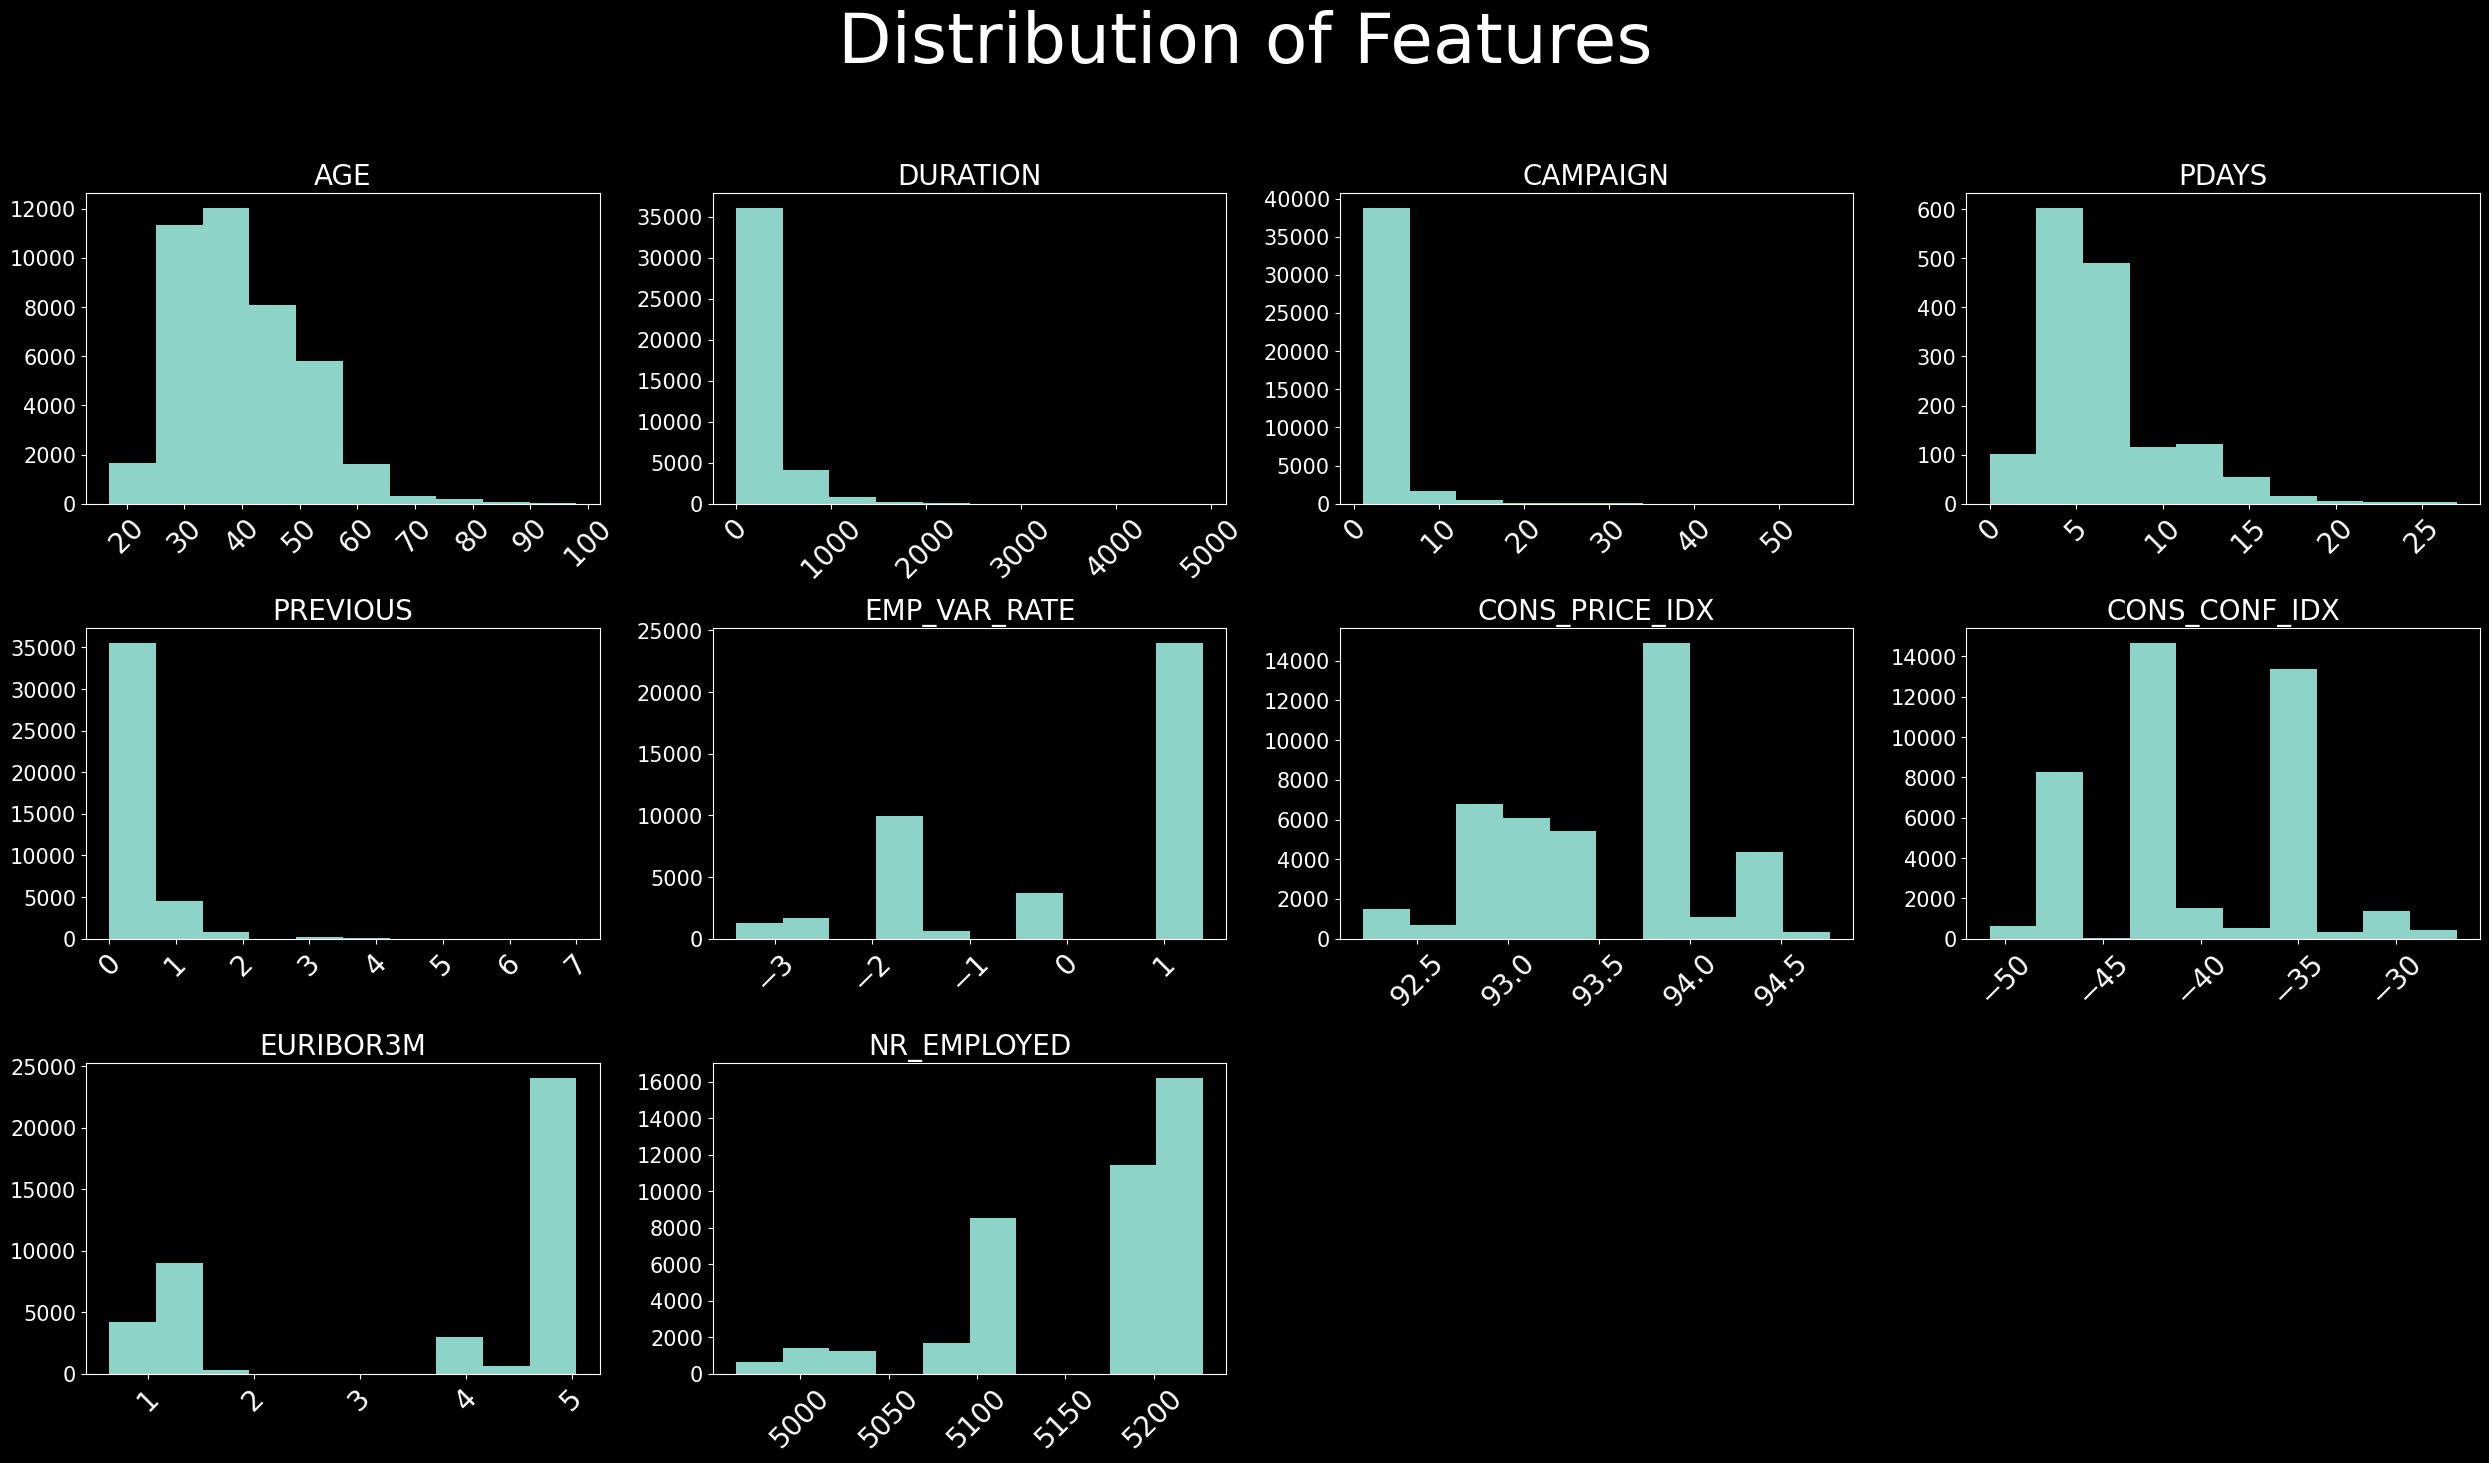

In [26]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df3.toPandas().describe().columns, range(1,22)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df3.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [240]:
df3.groupby("y").count().show()

+---+-----+
|  y|count|
+---+-----+
| no|36548|
|yes| 4640|
+---+-----+



In [29]:
df3.groupby("wasPreviouslyContacted").count().show()

+----------------------+-----+
|wasPreviouslyContacted|count|
+----------------------+-----+
|                  true| 1515|
|                 false|39673|
+----------------------+-----+



In [34]:
df3.groupby("job").count().show()

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 2924|
|      retired| 1720|
|      unknown|  330|
|self-employed| 1421|
|      student|  875|
|  blue-collar| 9254|
| entrepreneur| 1456|
|       admin.|10422|
|   technician| 6743|
|     services| 3969|
|    housemaid| 1060|
|   unemployed| 1014|
+-------------+-----+



In [30]:
df3.groupby("marital").count().show()

+--------+-----+
| marital|count|
+--------+-----+
| unknown|   80|
|divorced| 4612|
| married|24928|
|  single|11568|
+--------+-----+



In [213]:
df_renamed.groupby("education").count().show()

+-------------------+-----+
|          education|count|
+-------------------+-----+
|        high.school| 9515|
|            unknown| 1731|
|           basic.6y| 2292|
|professional.course| 5243|
|  university.degree|12168|
|         illiterate|   18|
|           basic.4y| 4176|
|           basic.9y| 6045|
+-------------------+-----+



In [214]:
df_renamed.groupby("default").count().show()

+-------+-----+
|default|count|
+-------+-----+
|unknown| 8597|
|     no|32588|
|    yes|    3|
+-------+-----+



In [35]:
df3.groupby("housing").count().show()

+-------+-----+
|housing|count|
+-------+-----+
|unknown|  990|
|     no|18622|
|    yes|21576|
+-------+-----+



In [36]:
df3.groupby("loan").count().show()

+-------+-----+
|   loan|count|
+-------+-----+
|unknown|  990|
|     no|33950|
|    yes| 6248|
+-------+-----+



In [37]:
df3.groupby("contact").count().show()

+---------+-----+
|  contact|count|
+---------+-----+
| cellular|26144|
|telephone|15044|
+---------+-----+



In [39]:
df3.groupby("month").count().show()

+-----+-----+
|month|count|
+-----+-----+
|  jun| 5318|
|  aug| 6178|
|  may|13769|
|  mar|  546|
|  oct|  718|
|  jul| 7174|
|  nov| 4101|
|  apr| 2632|
|  dec|  182|
|  sep|  570|
+-----+-----+



In [99]:
df3.groupby("day_of_week").count().show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|        fri| 7827|
|        thu| 8623|
|        tue| 8090|
|        wed| 8134|
|        mon| 8514|
+-----------+-----+



In [40]:
df3.groupby("poutcome").count().show()

+-----------+-----+
|   poutcome|count|
+-----------+-----+
|    success| 1373|
|    failure| 4252|
|nonexistent|35563|
+-----------+-----+



In [242]:
df4=df3.withColumn("marital",when(df3.marital=="unknown",np.nan).otherwise(df3.marital))\
.withColumn("education",when(df3.education=="unknown",np.nan).otherwise(df3.education))\
.withColumn("default",when(df3.default=="unknown",np.nan).otherwise(df3.default))\
.withColumn("housing",when(df3.housing=="unknown",np.nan).otherwise(df3.housing))\
.withColumn("loan",when(df3.loan=="unknown",np.nan).otherwise(df3.loan))\
.withColumn("y_int",when(df3.pdays=="no",0).otherwise(1))

In [243]:
df4.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df4.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+----------------------+-----+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|wasPreviouslyContacted|y_int|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+----------------------+-----+
|  0|  0|     80|     1731|   8597|    990| 990|      0|    0|          0|       0|       0|39673|       0|       0|           0|             0|            0|        0|          0|  0|                     0|    0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+

In [229]:
from pyspark.ml.feature import QuantileDiscretizer
#education_udf = udf(udf_multiple)
#df3.withColumn("age_group",pd.qcut(df3.age, q=5)).show(5)


qds1 = QuantileDiscretizer(inputCol="age", outputCol="age_buckets")
qds1.setNumBuckets(5)
qds1.setRelativeError(0.01)
qds1.setHandleInvalid("error")
bucketizer = qds1.fit(df4)
qds1.setHandleInvalid("keep").fit(df4).transform(df4).count()

41188

In [230]:
qds1.setHandleInvalid("skip").fit(df4).transform(df4).count()

41188

In [231]:
splits = bucketizer.getSplits()
splits

[-inf, 31.0, 35.0, 41.0, 49.0, inf]

In [232]:
df5 = qds1.setHandleInvalid("keep").fit(df4).transform(df4)

In [233]:
df5.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+----------------------+-----------+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|wasPreviouslyContacted|age_buckets|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+----------------------+-----------+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  NaN|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|                     0|        4.0|
| 57| services|married|high.school|    NaN|     no|  no|telephone|  

# Feature Groups

In [ ]:
categorical_features = [t[0] for t in df.dtypes if t[1] == 'string' and t[0] != "y"]
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [252]:
numeric_features = [t[0] for t in df4.dtypes if t[1] != 'string' and t[0] != 'wasPreviouslyContacted' and t[0]!='y_int']
numeric_features

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed']

# Correlation

## Pearson 

In [254]:
numeric_features_df=df4.select(numeric_features)

col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,-0.000866,0.004594,NaN,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,NaN,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,NaN,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
previous,0.024365,0.020640,-0.079141,NaN,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp_var_rate,-0.000371,-0.027968,0.150754,NaN,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons_price_idx,0.000857,0.005312,0.127836,NaN,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons_conf_idx,0.129372,-0.008173,-0.013733,NaN,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,NaN,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr_employed,-0.017725,-0.044703,0.144095,NaN,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


In [ ]:
# pick one, drop others, correlated features: euribor3m, emp_var_rate, nr_employed

df4.select(['euribor3m', 'emp_var_rate', 'nr_employed', 'y_int'])

In [212]:
cols = encoder.getOutputCols()+numeric_features

from pyspark.sql.functions import isnan, when, count, col
d4.select([count(when(isnan(c), c)).alias(c) for c in numeric_features]).toPandas().head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,0,0,0,39673,0,0,0,0,0,0


In [126]:
from pyspark.ml.feature import OneHotEncoder

indexers = [
    StringIndexer(inputCol= col, outputCol="{0}_indexed".format(col))
    for col in categorical_features
]

y_indexer = [StringIndexer(inputCol= "y",
                          outputCol="label")]

encoder = OneHotEncoder(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=[
        "{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers]
)

assembler = VectorAssembler(
    inputCols=encoder.getOutputCols()+numeric_features,
    outputCol="vectorized_features"
)

scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("scaled_features")
         #.setHandleInvalid("skip")

pipeline = Pipeline(stages=indexers + y_indexer + [encoder, assembler, scaler])
df5 = pipeline.fit(df3).transform(df3)

In [225]:
pipeline.getStages()

[StringIndexer_c349a6ebce97,
 StringIndexer_010952ffe67b,
 StringIndexer_c74c4198b814,
 StringIndexer_a5035b29f04a,
 StringIndexer_5485a74dc390,
 StringIndexer_6579f6303f8a,
 StringIndexer_a3fa8b4f27f1,
 StringIndexer_3eabebd3605f,
 StringIndexer_30fa15acfc9d,
 StringIndexer_5ed0c788b4af,
 StringIndexer_7577f5d52423,
 OneHotEncoder_ccbd316df378,
 VectorAssembler_124985e0938c,
 StandardScaler_14bf091a7fc4]

In [88]:
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option("display.max_columns", 12)

In [117]:
df5.toPandas().scaled_features.head()

0    (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.315223743272895, 0.0, 0.0, 2.0457...
1    (0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.045...
2    (0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.045...
3    (2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0457...
4    (0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.045...
Name: scaled_features, dtype: object

In [163]:
train, test = df5.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32894
Test Dataset Count: 8294


In [129]:
df5.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|36548|
|  1.0| 4640|
+-----+-----+



In [185]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'label', maxIter=15)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'scaled_features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,scaled_features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.934878333042953, 0.0, 2...","[4.234135526064389, -4.234135526064389]",0.0,"[0.9857146943781643, 0.01428530562183572]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.934878333042953, 0.0, 2...","[2.3563827007591804, -2.3563827007591804]",0.0,"[0.9134402232576287, 0.08655977674237125]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.934878333042953, 0.0, 2...","[0.6335396047995907, -0.6335396047995907]",0.0,"[0.6532916230287572, 0.3467083769712428]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.934878333042953, 0.0, 2...","[1.9861797575332183, -1.9861797575332183]",0.0,"[0.8793383877266736, 0.12066161227332639]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.934878333042953, 0.0, 2...","[2.500081830035878, -2.500081830035878]",0.0,"[0.9241475563692972, 0.07585244363070276]"


In [186]:

lr2 = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'label', maxIter=15)

lrModel2 = lr2.fit(train_over)

predictions2 = lrModel2.transform(test)

#predictions_train = lrModel.transform(train)
predictions2.select('label', 'scaled_features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,scaled_features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.934878333042953, 0.0, 2...","[2.8302202832209176, -2.8302202832209176]",0.0,"[0.9442871920615403, 0.055712807938459674]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.934878333042953, 0.0, 2...","[0.39960898927414235, -0.39960898927414235]",0.0,"[0.5985937119597964, 0.4014062880402036]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.934878333042953, 0.0, 2...","[-2.0814646010197038, 2.0814646010197038]",1.0,"[0.11091145992397436, 0.8890885400760257]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.934878333042953, 0.0, 2...","[-0.09900582461533247, 0.09900582461533247]",1.0,"[0.47526874217833387, 0.5247312578216661]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.934878333042953, 0.0, 2...","[0.6384482752883258, -0.6384482752883258]",0.0,"[0.654402606933156, 0.345597393066844]"


In [187]:
predictions.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  410|
|  0.0|       1.0|  199|
|  1.0|       0.0|  532|
|  0.0|       0.0| 7153|
+-----+----------+-----+



In [188]:
predictions2.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  831|
|  0.0|       1.0|  975|
|  1.0|       0.0|  111|
|  0.0|       0.0| 6377|
+-----+----------+-----+



In [189]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 410  532]
 [ 199 7153]]


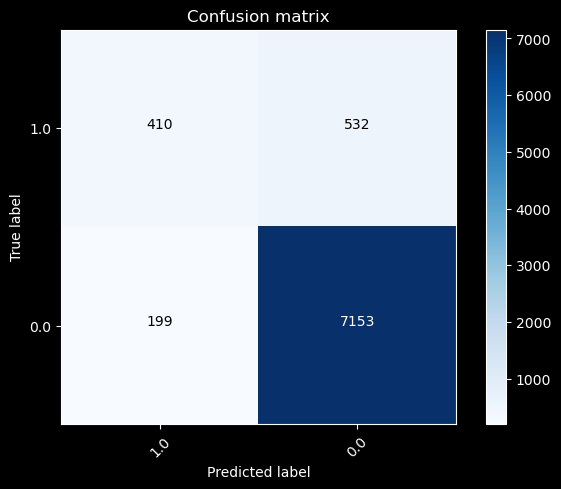

In [190]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

Confusion matrix, without normalization
[[ 831  111]
 [ 975 6377]]


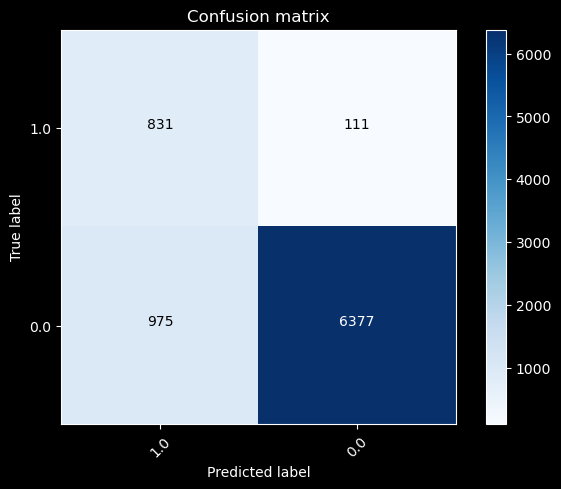

In [191]:
y_true = predictions2.select("label")
y_true = y_true.toPandas()

y_pred = predictions2.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [192]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9118639980708946


In [193]:
accuracy = predictions2.filter(predictions.label == predictions2.prediction).count() / float(predictions2.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8690619725102484


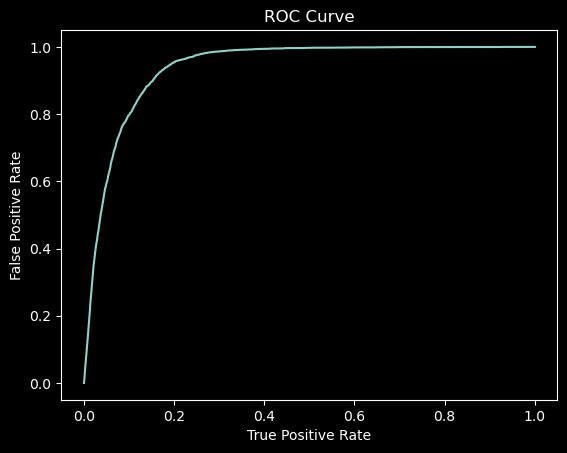

Training set areaUnderROC: 0.9381170319495461


In [172]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [195]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))
print('Test Area Under ROC oversampled', evaluator.evaluate(predictions2))

Test Area Under ROC 0.9369017833008724
Test Area Under ROC oversampled 0.9410510362736191


In [175]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])# regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])# Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, [1, 5, 10])#Number of iterations
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train_over)

In [176]:
## Evaluate Best Model
predictions = cvModel.transform(test)
print('Best Model Test Area Under ROC', evaluator.evaluate(predictions))

Best Model Test Area Under ROC 0.9396236476230736


In [177]:
cvModel.bestModel

LogisticRegressionModel: uid=LogisticRegression_d49481dbb0bc, numClasses=2, numFeatures=54

In [178]:
weights = cvModel.bestModel.coefficients
weights = [(float(w),) for w in weights]
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
weightsDF.toPandas().head(10)

,Feature Weight
0,0.000000
1,-0.093164
2,0.000000
3,-0.016581
4,0.000000
5,0.054526
6,0.000000
7,0.000000
8,0.000000
9,0.000000


In [179]:
best_model=cvModel.bestModel

In [180]:
best_model.explainParams().split("\n")

['aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)',
 'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.5)',
 'family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)',
 'featuresCol: features column name. (default: features, current: scaled_features)',
 'fitIntercept: whether to fit an intercept term. (default: True)',
 'labelCol: label column name. (default: label, current: label)',
 'lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)',
 'lowerBoundsOnIntercepts: The lower bounds on intercepts i

Confusion matrix, without normalization
[[ 822  120]
 [ 968 6384]]


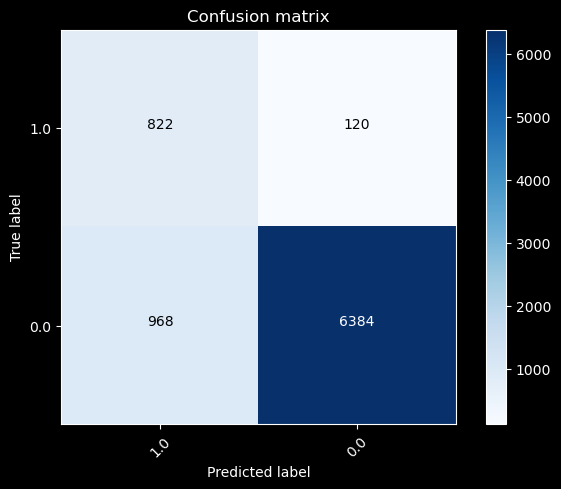

In [181]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [157]:
major_df = df5.filter(col("label") == 0)
minor_df = df5.filter(col("label") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 7


In [158]:
a = range(ratio)

In [159]:
from pyspark.sql.functions import col, explode, array, lit
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

In [160]:
# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)

In [162]:
train_over, test_over = combined_df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 55222
Test Dataset Count: 13806


In [166]:
train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|29196|
|  1.0| 3698|
+-----+-----+



In [165]:
train_over.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|29185|
|  1.0|26037|
+-----+-----+

